# SVM with rbf kernel

The goal of this notebook is to find the best parameters for polynomial kernel. We also want to check if the parameters depend on stock.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)
* gamma (default 1/number_of_features, so 1 in our case)

Kernel function looks like this: $\exp(-\gamma \|x-x'\|^2)$. $\gamma$ is specified by keyword **gamma**, must be greater than 0.

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

from lob_data_utils import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['3757', '4218', '4851', '3388', '3107']

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_prepared_data(s, cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 3757: 3030
Testing set length for 3757: 1010
Cross-validation set length for 3757: 1010
Training set length for 4218: 3030
Testing set length for 4218: 1010
Cross-validation set length for 4218: 1010
Training set length for 4851: 3030
Testing set length for 4851: 1010
Cross-validation set length for 4851: 1010
Training set length for 3388: 3030
Testing set length for 3388: 1010
Cross-validation set length for 3388: 1010
Training set length for 3107: 3030
Testing set length for 3107: 1010
Cross-validation set length for 3107: 1010


In [3]:
dfs[stocks[0]].head(5)

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
1010,2013-09-09 14:55:00,"[(1541.0, 1212.0), (1585.0, 3600.0), (1588.0, ...","[(1617.0, 382.0), (1618.0, 1611.0), (1619.0, 3...",1615.0,1617.0,1616.0,382.0,1010.0,1.0,0.451149
1011,2013-09-09 14:56:00,"[(1541.0, 1212.0), (1585.0, 3600.0), (1588.0, ...","[(1619.0, 2003.0), (1620.0, 4657.0), (1621.0, ...",1616.0,1619.0,1617.5,2003.0,1436.0,0.0,-0.164874
1012,2013-09-09 14:57:00,"[(1541.0, 1212.0), (1585.0, 3600.0), (1588.0, ...","[(1618.0, 414.0), (1619.0, 2541.0), (1620.0, 5...",1616.0,1618.0,1617.0,414.0,1136.0,1.0,0.465806
1013,2013-09-10 09:00:00,"[(1320.0, 15.0), (1560.0, 19.0), (1571.0, 1157...","[(1636.0, 96.0), (1637.0, 800.0), (1638.0, 865...",1634.0,1636.0,1635.0,96.0,167.0,0.0,0.269962
1014,2013-09-10 09:04:00,"[(1320.0, 15.0), (1560.0, 19.0), (1571.0, 1157...","[(1635.0, 112.0), (1636.0, 557.0), (1637.0, 19...",1633.0,1635.0,1634.0,112.0,801.0,1.0,0.754655


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults.

After that we will try to get the best combination of the parameters.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced or removed.

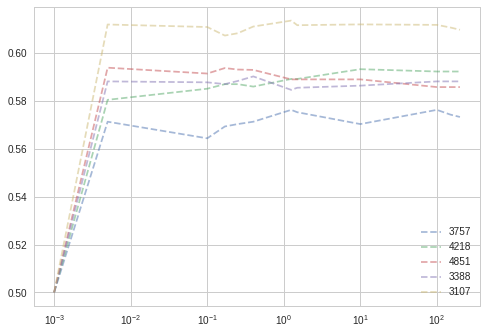

In [5]:
cs = [0.001, 0.005, 0.1, 0.17, 0.25, 0.4, 1.25, 1.5, 10, 100, 150, 200]
df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'rbf', C=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.5)
    df_css[s] = df_cs
    
plt.legend()

##### Best values of C parameter

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 3757 the best is 1.25
For 4218 the best is 10.0
For 4851 the best is 0.005
For 3388 the best is 0.4
For 3107 the best is 1.25


##### Influence of C parameter

In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 3757 the diff between best and worst 0.0762376237623763
For 4218 the diff between best and worst 0.09322349710699229
For 4851 the diff between best and worst 0.0938457534278988
For 3388 the diff between best and worst 0.09020969686024016
For 3107 the diff between best and worst 0.11350967275924884


### Gamma

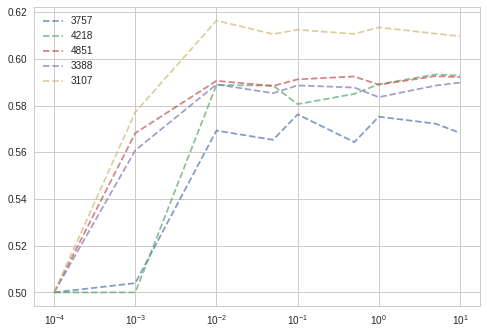

In [8]:
gammas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]

df_gammas = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_gamma = pd.DataFrame(index=gammas)
    df_gamma['roc'] = np.zeros(len(df_gamma))
    for g in gammas:
        reg_svm = svm_classification(dfs[s], 'rbf', gamma=g)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))

        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_gamma.loc[g] = logit_roc_auc
    plt.plot(df_gamma, linestyle='--', label=s, marker='x', alpha=0.7)
    df_gammas[s] = df_gamma
    
plt.legend()

##### Best values of gamma

In [9]:
for s in stocks:
    idx = df_gammas[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 3757 the best is 0.1
For 4218 the best is 5.0
For 4851 the best is 5.0
For 3388 the best is 10.0
For 3107 the best is 0.01


##### Influence of gamma

In [10]:
for s in stocks:
    err_max = df_gammas[s]['roc'].max()
    err_min = df_gammas[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 3757 the diff between best and worst 0.0762376237623763
For 4218 the diff between best and worst 0.09334117877807191
For 4851 the diff between best and worst 0.0926252361178479
For 3388 the diff between best and worst 0.08986026752937759
For 3107 the diff between best and worst 0.11640678977451158


# Results

We compare results of the SVMs with the best choices of parameters against the logistic regression and SVM with defaults.

We will use two approaches for choosing parameters:
* naive - for each stock we will just pick the best values we found in the previous section
* grid - we will caluclate roc_area error for every combination of parameters used in previous section (computionally heavy).

We could also use GridSearchCV from sklearn library, but the issue with it is supplying the cross-validation set (it has to be continous in time). In the future we need to implement the method for that.

#### Naive approach

We pick the best **C** parameter and the best **gamma** separately from the results of [section above](#Methodology), which were obtained using cross-validation set.

In [11]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['rbf-naive'] = np.zeros(len(stocks))
df_results['rbf-default'] = np.zeros(len(stocks))

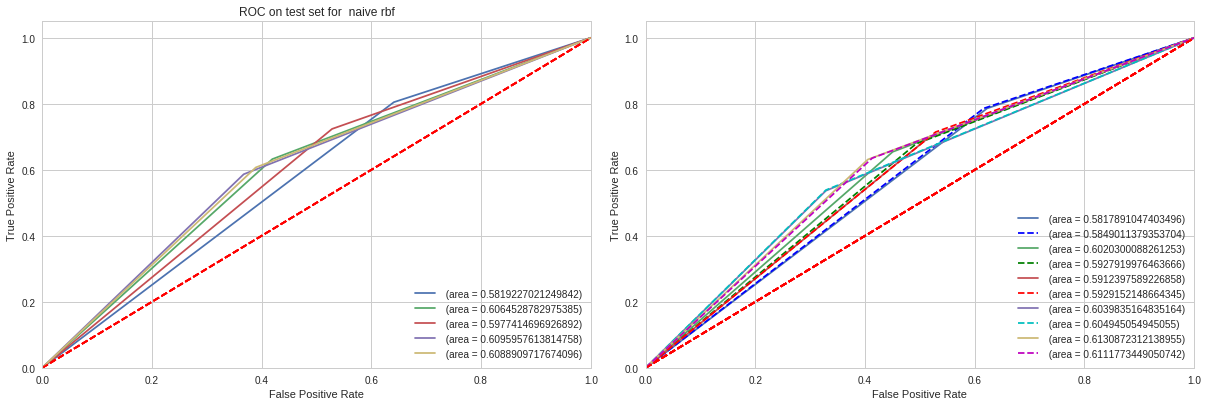

In [12]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf', C=df_css[s]['roc'].idxmax(), gamma=df_gammas[s]['roc'].idxmax())
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC on test set for  naive rbf')
    df_results['rbf-naive'][s] = score

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf')
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC on test set for default')
    df_results['rbf-default'][s] = score

    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    score = lob.plot_roc(dfs_test[s], reg_log, c=colors[stocks.index(s)], linestyle='--')
    df_results['logistic'][s] = score
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [13]:
df_results

,logistic,rbf-naive,rbf-default
3757,0.584901,0.581923,0.581789
4218,0.592792,0.606453,0.602030
4851,0.592915,0.597741,0.591240
3388,0.604945,0.609596,0.603984
3107,0.611177,0.608891,0.613087


### Grid approach

We iterate over all combinations of parameters **C** and **gamma**.

This approach works usually better, but not for all cases.

In [14]:
df_params = {}

for s in stocks:
    print(s)
    params = []
    for c in cs:
        for g in gammas:
            reg_svm = svm_classification(dfs[s], 'rbf', C=c, gamma=g)
            prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
            score = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
            params.append({'score': score, 'gamma': g, 'c': c})
    df_params[s] = pd.DataFrame(params)
df_params[stocks[0]]

3757
4218
4851
3388
3107


,c,gamma,score
0,0.001,0.0001,0.500000
1,0.001,0.0010,0.500000
2,0.001,0.0100,0.500000
3,0.001,0.0500,0.500000
4,0.001,0.1000,0.500000
5,0.001,0.5000,0.500000
6,0.001,1.0000,0.500000
7,0.001,5.0000,0.500000
8,0.001,10.0000,0.500000
9,0.005,0.0001,0.500000


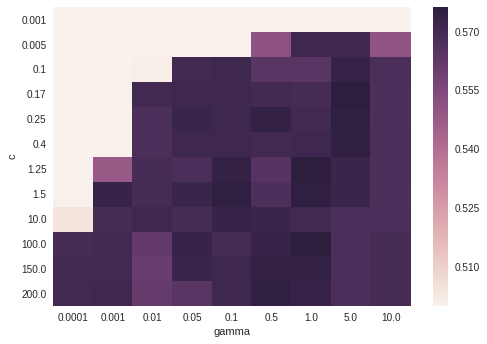

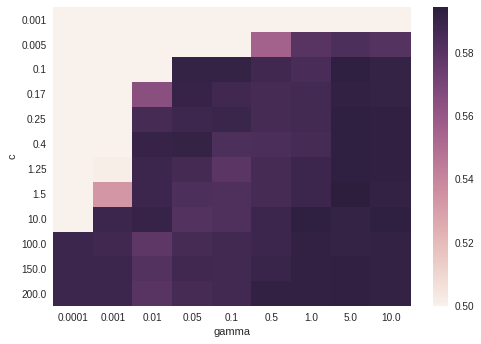

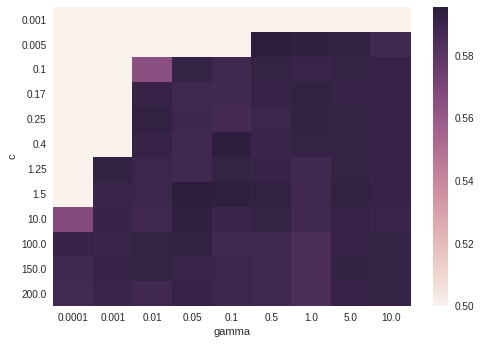

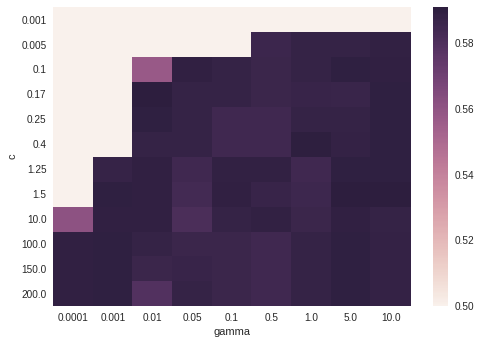

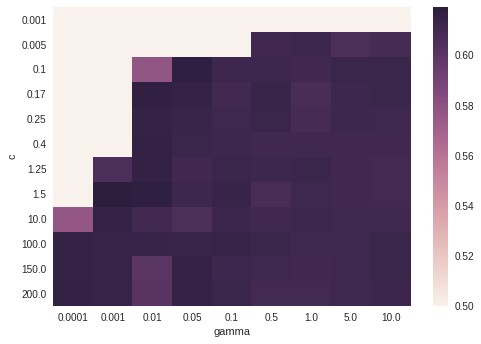

In [15]:
for s in stocks:
    df_g = df_params[s].pivot(index='c', columns='gamma', values='score')
    sns.heatmap(df_g)
    plt.figure()

##### Best parameters for grid approach

In [16]:
for s in stocks:
    print(df_params[s].iloc[df_params[s]['score'].idxmax()])

c        1.250000
gamma    1.000000
score    0.576238
Name: 60, dtype: float64
c        1.500000
gamma    5.000000
score    0.594351
Name: 70, dtype: float64
c        0.005000
gamma    0.500000
score    0.595579
Name: 14, dtype: float64
c        0.17000
gamma    0.01000
score    0.59085
Name: 29, dtype: float64
c        1.500000
gamma    0.001000
score    0.619214
Name: 64, dtype: float64


3757 60
	 1.25 1.0
4218 70
	 1.5 5.0
4851 14
	 0.005 0.5
3388 29
	 0.17 0.01
3107 64
	 1.5 0.001


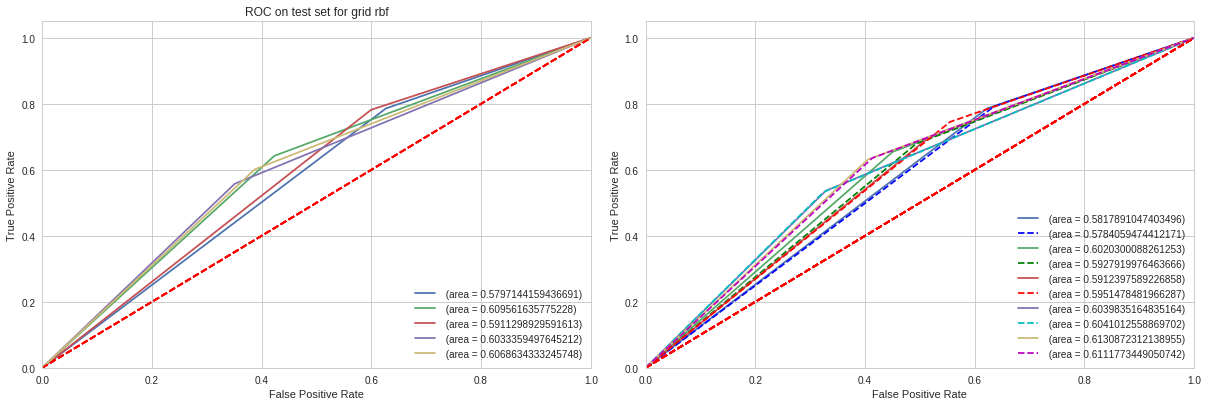

In [18]:
df_results['rbf-grid'] = np.zeros(len(stocks))

plt.subplot(121)
for s in stocks:
    best_idx = df_params[s]['score'].idxmax()
    print(s, best_idx)
    print('\t', df_params[s]['c'].iloc[best_idx], df_params[s]['gamma'].iloc[best_idx])
    reg_svm = svm_classification(dfs[s], 'rbf', C=df_params[s].iloc[best_idx]['c'], 
                                 gamma=df_params[s].iloc[best_idx]['gamma'])
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC on test set for grid rbf')
    df_results['rbf-grid'][s] = score

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf')
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC on test set for default')
    df_results['rbf-default'][s] = score

    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    score = lob.plot_roc(dfs_test[s], reg_log, c=colors[stocks.index(s)], linestyle='--')
    df_results['logistic'][s] = score
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [19]:
df_results

,logistic,rbf-naive,rbf-default,rbf-grid
3757,0.578406,0.581923,0.581789,0.579714
4218,0.592792,0.606453,0.602030,0.609562
4851,0.595148,0.597741,0.591240,0.591130
3388,0.604101,0.609596,0.603984,0.603336
3107,0.611177,0.608891,0.613087,0.606863


# Conclusions

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>
2. [RBF kernel](https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/)
3. [model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)